
1. Veri setleri yükleniyor...
Siparişler: 104101 kayıt
Ürünler: 49688 kayıt
Eğitim sipariş ürünleri: 247172 kayıt
Önceki sipariş ürünleri: 201539 kayıt

2. Veri analizi ve ön işleme yapılıyor...

En çok tekrar sipariş edilen 10 ürün:
                 product_name  reorder_count
7469                   Banana           2519
3936   Bag of Organic Bananas           1987
6348     Organic Strawberries           1202
6583     Organic Baby Spinach           1162
14141    Organic Hass Avocado           1060
14286         Organic Avocado            857
8341       Organic Whole Milk            692
8383      Organic Raspberries            640
5050             Strawberries            633
14247             Large Lemon            627

Birlikte alınan ürünler analiz ediliyor...

En sık birlikte alınan 5 ürün çifti:
           product_1_name        product_2_name  co_occurrence
0  Bag of Organic Bananas  Organic Hass Avocado            374
1    Organic Strawberries                Banana            357

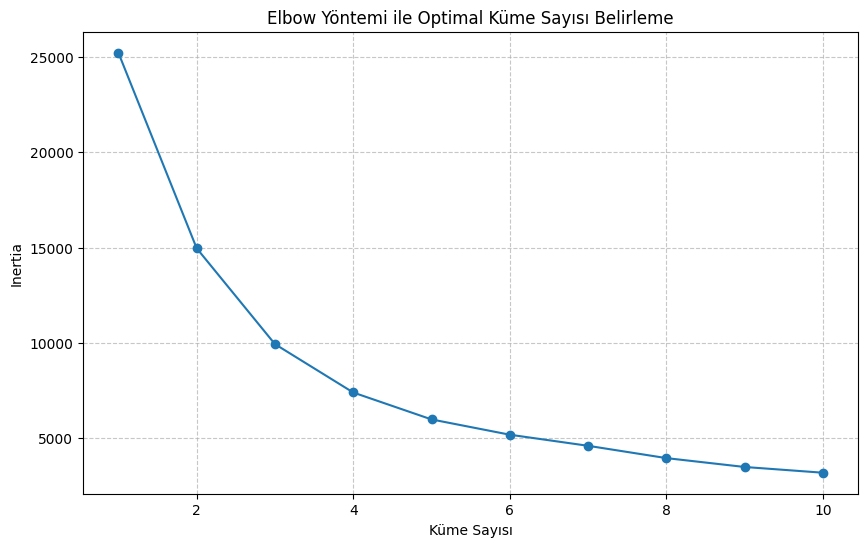

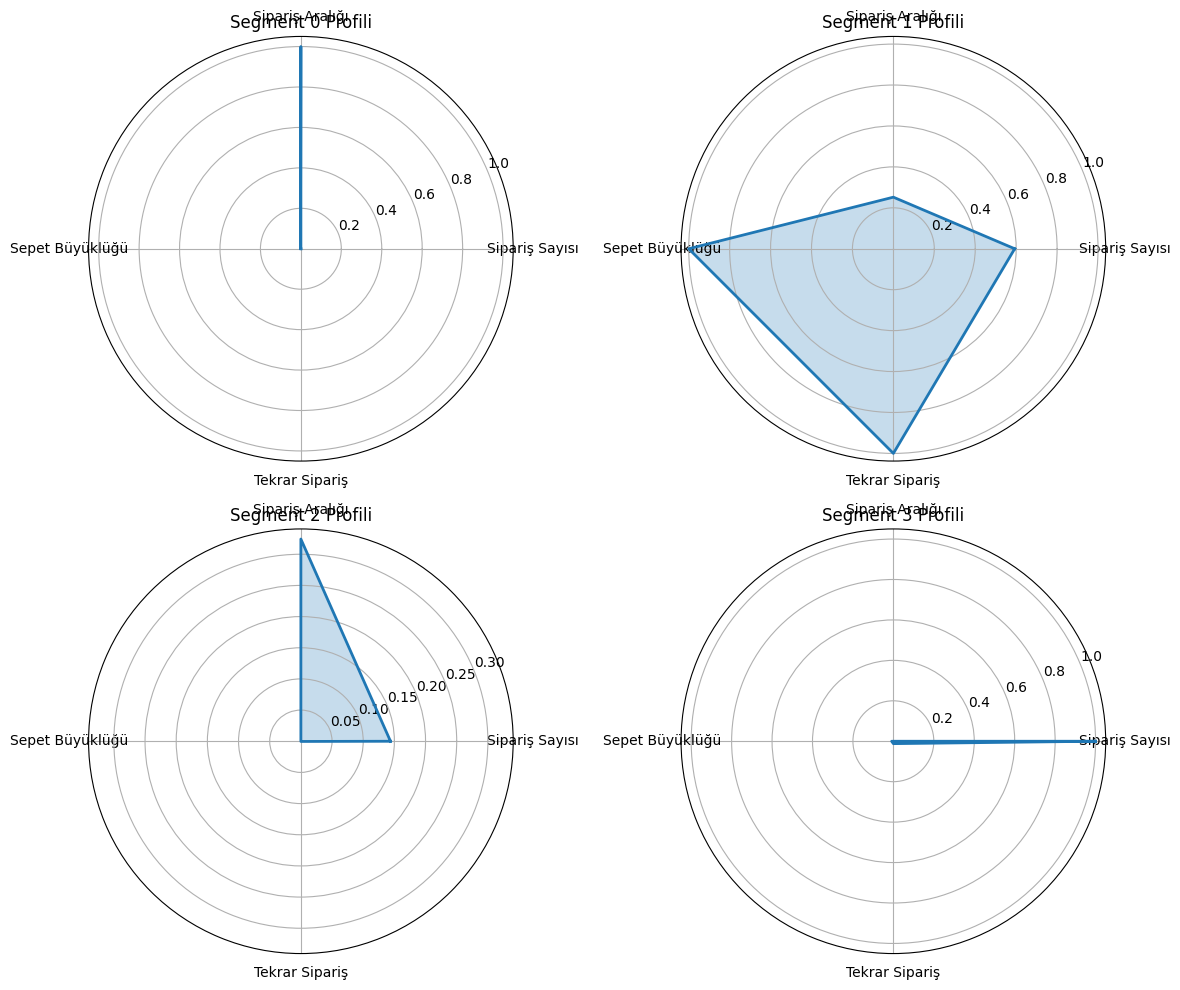

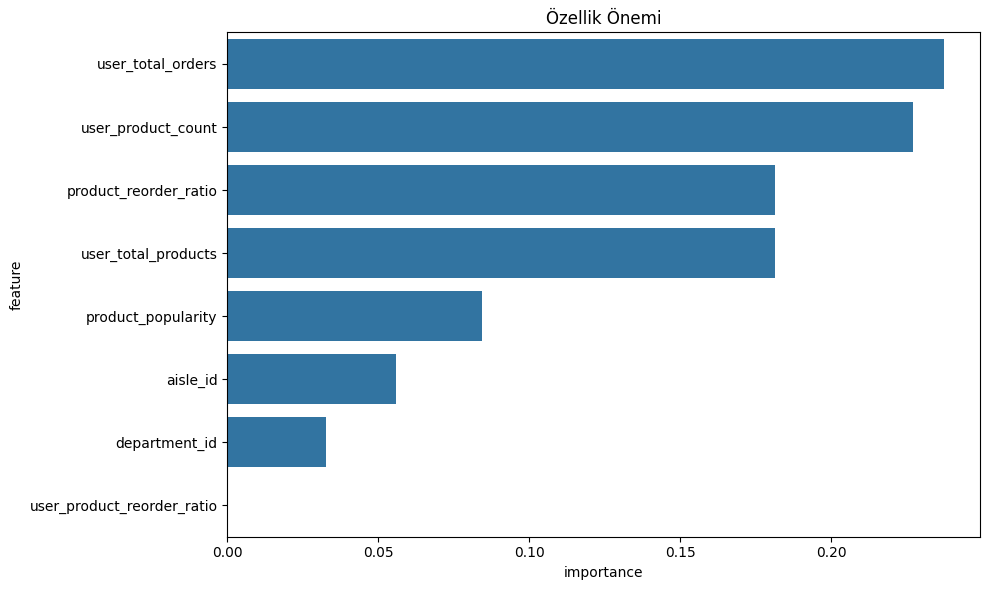

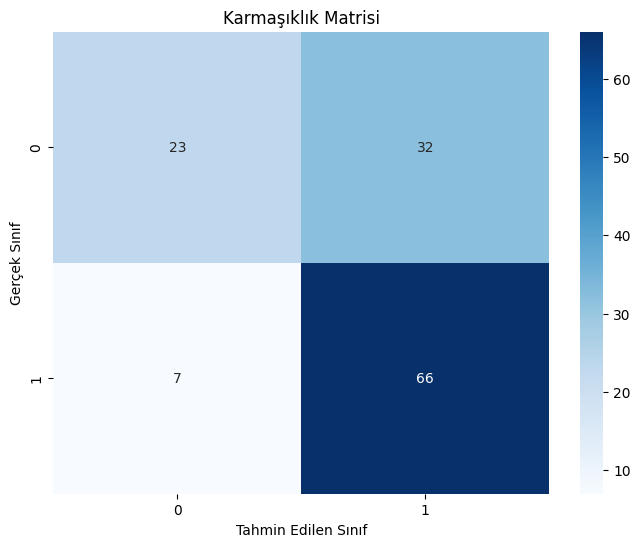

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
import pickle
import os
from collections import defaultdict
from datetime import datetime

# Uyarıları bastıralım
warnings.filterwarnings('ignore')

# Veri setlerinin yollarını belirleyelim
def load_data():
    print("\n1. Veri setleri yükleniyor...")

    try:
        orders = pd.read_csv("orders.csv")
        products = pd.read_csv("products.csv")
        order_products_train = pd.read_csv("order_products__train.csv")
        order_products_prior = pd.read_csv("order_products__prior.csv")
        departments = pd.read_csv("departments.csv")
        aisles = pd.read_csv("aisles.csv")

        print(f"Siparişler: {orders.shape[0]} kayıt")
        print(f"Ürünler: {products.shape[0]} kayıt")
        print(f"Eğitim sipariş ürünleri: {order_products_train.shape[0]} kayıt")
        print(f"Önceki sipariş ürünleri: {order_products_prior.shape[0]} kayıt")

        return orders, products, order_products_train, order_products_prior, departments, aisles

    except FileNotFoundError:
        print("\nUYARI: Veri dosyaları bulunamadı!")
        print("Bu kod, Instacart Market Basket Analysis veri setini kullanır.")
        print("Veri setini https://www.kaggle.com/c/instacart-market-basket-analysis/data adresinden indirebilirsiniz.")
        print("Alternatif olarak, veri seti yoksa örnek veri oluşturulacak...")
        return create_sample_data()

def create_sample_data(n_users=1000, n_products=200, n_orders=2000):
    print("Örnek veri oluşturuluyor...")

    departments = pd.DataFrame({
        'department_id': range(1, 21),
        'department': [f'Departman_{i}' for i in range(1, 21)]
    })

    aisles = pd.DataFrame({
        'aisle_id': range(1, 101),
        'aisle': [f'Koridor_{i}' for i in range(1, 101)]
    })

    products = pd.DataFrame({
        'product_id': range(1, n_products + 1),
        'product_name': [f'Ürün_{i}' for i in range(1, n_products + 1)],
        'aisle_id': np.random.choice(aisles['aisle_id'], size=n_products),
        'department_id': np.random.choice(departments['department_id'], size=n_products)
    })

    orders = pd.DataFrame({
        'order_id': range(1, n_orders + 1),
        'user_id': np.random.randint(1, n_users + 1, size=n_orders),
        'order_number': np.random.randint(1, 100, size=n_orders),
        'order_dow': np.random.randint(0, 7, size=n_orders),
        'order_hour_of_day': np.random.randint(0, 24, size=n_orders),
        'days_since_prior_order': np.random.randint(1, 30, size=n_orders),
        'eval_set': np.random.choice(['prior', 'train', 'test'], size=n_orders, p=[0.8, 0.1, 0.1])
    })

    prior_orders = orders[orders['eval_set'] == 'prior']
    train_orders = orders[orders['eval_set'] == 'train']

    order_products_prior = []
    for order_id in prior_orders['order_id']:
        n_products_in_order = np.random.randint(1, 20)
        products_in_order = np.random.choice(products['product_id'], size=n_products_in_order, replace=False)

        for i, product_id in enumerate(products_in_order):
            reordered = np.random.choice([0, 1], p=[0.4, 0.6])
            order_products_prior.append({
                'order_id': order_id,
                'product_id': product_id,
                'add_to_cart_order': i + 1,
                'reordered': reordered
            })

    order_products_prior = pd.DataFrame(order_products_prior)

    order_products_train = []
    for order_id in train_orders['order_id']:
        n_products_in_order = np.random.randint(1, 20)
        products_in_order = np.random.choice(products['product_id'], size=n_products_in_order, replace=False)

        for i, product_id in enumerate(products_in_order):
            reordered = np.random.choice([0, 1], p=[0.4, 0.6])
            order_products_train.append({
                'order_id': order_id,
                'product_id': product_id,
                'add_to_cart_order': i + 1,
                'reordered': reordered
            })

    order_products_train = pd.DataFrame(order_products_train)

    return orders, products, order_products_train, order_products_prior, departments, aisles

def analyze_data(orders, products, order_products_train, order_products_prior, departments, aisles):
    print("\n2. Veri analizi ve ön işleme yapılıyor...")


    products_info = products.merge(aisles, on='aisle_id', how='left')
    products_info = products_info.merge(departments, on='department_id', how='left')


    order_products_with_info = order_products_prior.merge(products_info, on='product_id', how='left')


    dept_popularity = order_products_with_info.groupby('department')['order_id'].count().reset_index()
    dept_popularity.columns = ['department', 'order_count']
    dept_popularity = dept_popularity.sort_values('order_count', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='order_count', y='department', data=dept_popularity.head(10))
    plt.title('En Popüler 10 Departman')
    plt.tight_layout()
    plt.savefig('populer_departmanlar.png')
    plt.close()


    plt.figure(figsize=(14, 7))
    hour_counts = orders['order_hour_of_day'].value_counts().sort_index()
    sns.lineplot(x=hour_counts.index, y=hour_counts.values)
    plt.title('Saatlere Göre Sipariş Dağılımı')
    plt.xlabel('Saat')
    plt.ylabel('Sipariş Sayısı')
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('saatlere_gore_siparis.png')
    plt.close()


    plt.figure(figsize=(10, 6))
    day_counts = orders['order_dow'].value_counts().sort_index()
    sns.barplot(x=day_counts.index, y=day_counts.values)
    plt.title('Haftanın Günlerine Göre Sipariş Dağılımı')
    plt.xlabel('Gün (0: Pazartesi, 6: Pazar)')
    plt.ylabel('Sipariş Sayısı')
    plt.savefig('gunlere_gore_siparis.png')
    plt.close()


    reordered_products = order_products_prior[order_products_prior['reordered'] == 1]
    product_reorder_counts = reordered_products.groupby('product_id').size().reset_index(name='reorder_count')
    product_reorder_counts = product_reorder_counts.merge(products_info[['product_id', 'product_name']], on='product_id')
    product_reorder_counts = product_reorder_counts.sort_values('reorder_count', ascending=False)

    print("\nEn çok tekrar sipariş edilen 10 ürün:")
    print(product_reorder_counts[['product_name', 'reorder_count']].head(10))


    print("\nBirlikte alınan ürünler analiz ediliyor...")


    order_groups = order_products_prior.groupby('order_id')['product_id'].apply(list)
    product_pairs = {}

    for products_in_order in order_groups:

        for i in range(len(products_in_order)):
            for j in range(i+1, len(products_in_order)):
                pair = tuple(sorted([products_in_order[i], products_in_order[j]]))
                product_pairs[pair] = product_pairs.get(pair, 0) + 1


    top_pairs = pd.DataFrame(
        [(p1, p2, cnt) for (p1, p2), cnt in product_pairs.items()],
        columns=['product_id_1', 'product_id_2', 'co_occurrence']
    ).sort_values('co_occurrence', ascending=False)


    top_pairs = top_pairs.merge(
        products_info[['product_id', 'product_name']].rename(columns={
            'product_id': 'product_id_1',
            'product_name': 'product_1_name'
        }),
        on='product_id_1'
    ).merge(
        products_info[['product_id', 'product_name']].rename(columns={
            'product_id': 'product_id_2',
            'product_name': 'product_2_name'
        }),
        on='product_id_2'
    )

    print("\nEn sık birlikte alınan 5 ürün çifti:")
    print(top_pairs[['product_1_name', 'product_2_name', 'co_occurrence']].head(5))

    return products_info, top_pairs
def time_based_recommendation(hour, products_info):
    """Saat bilgisine göre kategori önerisi"""

    departments = products_info['department'].unique()

    # Ensure we have enough departments for morning, evening, and other times
    if len(departments) < 3:
        departments = [f'Department_{i}' for i in range(len(departments), 3)]

    if 7 <= hour <= 10:
        # Morning time recommendation
        recommended_dept = departments[0]
        return products_info[products_info['department'] == recommended_dept].sample(min(3, len(products_info[products_info['department'] == recommended_dept])))
    elif 18 <= hour <= 21:
        # Evening time recommendation
        recommended_dept = departments[1] if len(departments) > 1 else departments[0]
        return products_info[products_info['department'] == recommended_dept].sample(min(3, len(products_info[products_info['department'] == recommended_dept])))
    else:
        # Other times recommendation
        recommended_dept = departments[2] if len(departments) > 2 else departments[0]
        return products_info[products_info['department'] == recommended_dept].sample(min(3, len(products_info[products_info['department'] == recommended_dept])))


def bundle_recommendation(product_id, top_pairs, products_info, n=3):
    """Birlikte alınan ürünleri önerir"""
    related = top_pairs[
        (top_pairs['product_id_1'] == product_id) |
        (top_pairs['product_id_2'] == product_id)
    ].nlargest(n, 'co_occurrence')

    product_ids = []
    for _, row in related.iterrows():
        if row['product_id_1'] == product_id:
            product_ids.append(row['product_id_2'])
        else:
            product_ids.append(row['product_id_1'])

    return products_info[products_info['product_id'].isin(product_ids)]


def customer_segmentation(orders, order_products_prior):
    print("\n3. Müşteri segmentasyonu yapılıyor...")

    order_sizes = order_products_prior.groupby('order_id').size().reset_index(name='order_size')
    orders_with_sizes = orders.merge(order_sizes, on='order_id', how='left')

    user_features = orders.groupby('user_id').agg({
        'order_id': 'count',
        'days_since_prior_order': 'mean',
        'order_hour_of_day': lambda x: x.mode()[0],
        'order_dow': lambda x: x.mode()[0]
    }).reset_index()

    user_features.columns = ['user_id', 'total_orders', 'avg_days_between_orders', 'most_common_hour', 'most_common_day']

    user_order_sizes = orders_with_sizes.groupby('user_id')['order_size'].mean().reset_index()
    user_order_sizes.columns = ['user_id', 'avg_order_size']

    user_reorder_rates = order_products_prior.groupby('order_id')['reordered'].mean().reset_index()
    user_reorder_rates = user_reorder_rates.merge(orders[['order_id', 'user_id']], on='order_id')
    user_reorder_rates = user_reorder_rates.groupby('user_id')['reordered'].mean().reset_index()
    user_reorder_rates.columns = ['user_id', 'reorder_rate']

    user_features = user_features.merge(user_order_sizes, on='user_id', how='left')
    user_features = user_features.merge(user_reorder_rates, on='user_id', how='left')
    user_features = user_features.fillna(0)

    features_for_clustering = user_features[['total_orders', 'avg_days_between_orders', 'avg_order_size', 'reorder_rate']]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_for_clustering)

    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Elbow Yöntemi ile Optimal Küme Sayısı Belirleme')
    plt.xlabel('Küme Sayısı')
    plt.ylabel('Inertia')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('elbow_method.png')

    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    user_features['cluster'] = kmeans.fit_predict(scaled_features)

    cluster_analysis = user_features.groupby('cluster').agg({
        'user_id': 'count',
        'total_orders': 'mean',
        'avg_days_between_orders': 'mean',
        'avg_order_size': 'mean',
        'reorder_rate': 'mean'
    }).reset_index()

    cluster_analysis.columns = ['Segment', 'Kullanıcı Sayısı', 'Ort. Sipariş Sayısı',
                              'Ort. Sipariş Aralığı (Gün)', 'Ort. Sepet Büyüklüğü',
                              'Tekrar Sipariş Oranı']

    print("\nMüşteri Segmentleri:")
    print(cluster_analysis)

    plt.figure(figsize=(12, 10))
    normalized = cluster_analysis.iloc[:, 2:].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    categories = ['Sipariş Sayısı', 'Sipariş Aralığı', 'Sepet Büyüklüğü', 'Tekrar Sipariş']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    for i in range(optimal_k):
        ax = plt.subplot(2, 2, i+1, polar=True)
        values = normalized.iloc[i].values.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Segment {i}')
        ax.fill(angles, values, alpha=0.25)
        plt.xticks(angles[:-1], categories)
        ax.set_title(f'Segment {i} Profili')

    plt.tight_layout()
    plt.savefig('customer_segments.png')

    return user_features

def recommend_products_for_user(user_id, user_features, segment_product_popularity, top_products_by_user, top_pairs, products_info, n=5):
    user_segment = user_features[user_features['user_id'] == user_id]['cluster'].values[0]
    user_products = top_products_by_user[top_products_by_user['user_id'] == user_id]['product_id'].tolist()

    if not user_products:
        segment_recommendations = segment_product_popularity[segment_product_popularity['cluster'] == user_segment]
        return segment_recommendations.merge(products_info[['product_id', 'product_name']], on='product_id').head(n)[['product_id', 'product_name']]

    top_user_products = top_products_by_user[top_products_by_user['user_id'] == user_id] \
                        .sort_values('purchase_count', ascending=False) \
                        .head(3)['product_id'].tolist()

    related_products = []
    for prod_id in top_user_products:
        related_1 = top_pairs[top_pairs['product_id_1'] == prod_id].sort_values('co_occurrence', ascending=False)
        related_2 = top_pairs[top_pairs['product_id_2'] == prod_id].sort_values('co_occurrence', ascending=False)

        if not related_1.empty:
            related_products.extend(related_1['product_id_2'].tolist())
        if not related_2.empty:
            related_products.extend(related_2['product_id_1'].tolist())

    recommendations = [p for p in related_products if p not in user_products]
    unique_recommendations = list(dict.fromkeys(recommendations))[:n]

    if len(unique_recommendations) < n:
        segment_recommendations = segment_product_popularity[segment_product_popularity['cluster'] == user_segment]
        segment_products = segment_recommendations['product_id'].tolist()
        for p in segment_products:
            if p not in unique_recommendations and p not in user_products:
                unique_recommendations.append(p)
                if len(unique_recommendations) >= n:
                    break

    recommendation_df = pd.DataFrame({'product_id': unique_recommendations[:n]})
    return recommendation_df.merge(products_info[['product_id', 'product_name']], on='product_id')

def build_recommendation_system(orders, products, order_products_prior, user_features, products_info):
    print("\n4. Ürün tavsiye sistemi oluşturuluyor...")

    user_product_matrix = order_products_prior.merge(orders[['order_id', 'user_id']], on='order_id')
    user_product_counts = user_product_matrix.groupby(['user_id', 'product_id']).size().reset_index(name='purchase_count')
    top_products_by_user = user_product_counts.sort_values(['user_id', 'purchase_count'], ascending=[True, False])

    user_segment_products = user_product_counts.merge(user_features[['user_id', 'cluster']], on='user_id')
    segment_product_popularity = user_segment_products.groupby(['cluster', 'product_id'])['purchase_count'].sum().reset_index()
    segment_product_popularity = segment_product_popularity.sort_values(['cluster', 'purchase_count'], ascending=[True, False])

    print("\nBirlikte satın alınan ürünleri analiz ediliyor...")
    product_pairs = defaultdict(int)
    order_groups = order_products_prior.groupby('order_id')['product_id'].apply(list).reset_index()
    sample_size = min(4000, len(order_groups))
    sampled_orders = order_groups.sample(sample_size, random_state=42)

    for _, row in sampled_orders.iterrows():
        products_in_order = row['product_id']
        for i in range(len(products_in_order)):
            for j in range(i+1, len(products_in_order)):
                product_pair = tuple(sorted([products_in_order[i], products_in_order[j]]))
                product_pairs[product_pair] += 1

    product_pairs_df = pd.DataFrame([(p1, p2, count) for (p1, p2), count in product_pairs.items()],
                                   columns=['product_id_1', 'product_id_2', 'co_occurrence'])

    product_pairs_df = product_pairs_df.merge(
        products_info[['product_id', 'product_name']].rename(columns={'product_id': 'product_id_1', 'product_name': 'product_1_name'}),
        on='product_id_1'
    )
    product_pairs_df = product_pairs_df.merge(
        products_info[['product_id', 'product_name']].rename(columns={'product_id': 'product_id_2', 'product_name': 'product_2_name'}),
        on='product_id_2'
    )

    top_pairs = product_pairs_df.sort_values('co_occurrence', ascending=False)
    print("\nEn sık birlikte satın alınan 10 ürün çifti:")
    print(top_pairs[['product_1_name', 'product_2_name', 'co_occurrence']].head(10))

    sample_user_id = user_features['user_id'].sample(1).values[0]
    recommendations = recommend_products_for_user(
        sample_user_id,
        user_features,
        segment_product_popularity,
        top_products_by_user,
        top_pairs,
        products_info
    )

    print(f"\nKullanıcı ID {sample_user_id} için tavsiye edilen ürünler:")
    print(recommendations)

    recommendation_system = {
        'user_features': user_features,
        'segment_product_popularity': segment_product_popularity,
        'top_products_by_user': top_products_by_user,
        'top_pairs': top_pairs,
        'products_info': products_info
    }

    with open('recommendation_system.pkl', 'wb') as f:
        pickle.dump(recommendation_system, f)

    return recommendation_system

def predict_reorders(orders, products, order_products_train, order_products_prior, products_info):
    print("\n5. Gradient Boosting ile ürün tekrar sipariş tahmini yapılıyor...")

    print("Özellikler oluşturuluyor...")
    user_orders = orders.groupby('user_id').size().reset_index(name='user_total_orders')
    user_product_features = order_products_prior.merge(orders[['order_id', 'user_id']], on='order_id')
    user_product_counts = user_product_features.groupby(['user_id', 'product_id']).size().reset_index(name='user_product_count')
    product_popularity = user_product_features.groupby('product_id')['user_id'].nunique().reset_index(name='product_popularity')
    user_total_products = user_product_features.groupby('user_id')['product_id'].nunique().reset_index(name='user_total_products')
    product_reorder_ratio = order_products_prior.groupby('product_id')['reordered'].mean().reset_index(name='product_reorder_ratio')
    user_product_reorder_ratio = user_product_features.groupby(['user_id', 'product_id'])['reordered'].mean().reset_index(name='user_product_reorder_ratio')

    sample_users = user_product_counts['user_id'].unique()[:1000]
    train_orders_sample = orders[orders['eval_set'] == 'train']
    train_orders_sample = train_orders_sample[train_orders_sample['user_id'].isin(sample_users)]
    last_orders = train_orders_sample.sort_values(['user_id', 'order_number'], ascending=[True, False]) \
                                    .drop_duplicates('user_id', keep='first')['order_id'].tolist()

    train_data = order_products_train[order_products_train['order_id'].isin(last_orders)]
    train_data = train_data.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
    train_features = train_data.merge(user_product_counts, on=['user_id', 'product_id'], how='left')
    train_features = train_features.merge(product_popularity, on='product_id', how='left')
    train_features = train_features.merge(user_total_products, on='user_id', how='left')
    train_features = train_features.merge(product_reorder_ratio, on='product_id', how='left')
    train_features = train_features.merge(user_product_reorder_ratio, on=['user_id', 'product_id'], how='left')
    train_features = train_features.merge(user_orders, on='user_id', how='left')
    train_features = train_features.merge(products_info[['product_id', 'department_id', 'aisle_id']], on='product_id', how='left')
    train_features = train_features.fillna(0)

    X = train_features[['user_product_count', 'product_popularity', 'user_total_products',
                       'product_reorder_ratio', 'user_product_reorder_ratio', 'user_total_orders',
                       'department_id', 'aisle_id']]
    y = train_features['reordered']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Model eğitiliyor...")
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    print("Hiperparametre optimizasyonu yapılıyor...")
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [2, 3]
    }

    grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"En iyi parametreler: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\nModel Performansı:")
    print(f"Doğruluk (Accuracy): {accuracy:.4f}")
    print(f"Kesinlik (Precision): {precision:.4f}")
    print(f"Duyarlılık (Recall): {recall:.4f}")
    print(f"F1 Skoru: {f1:.4f}")

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nÖzellik Önemleri:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Özellik Önemi')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Karmaşıklık Matrisi')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.ylabel('Gerçek Sınıf')
    plt.savefig('confusion_matrix.png')

    with open('reorder_prediction_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    return best_model

def generate_personalized_recommendations(user_id, recommendation_system, reorder_model, products_info):
    print(f"\n6. Kullanıcı {user_id} için kişiselleştirilmiş tavsiyeler oluşturuluyor...")

    # Varsayılan boş dönüş değeri
    default_return = {
        'standart_oneriler': pd.DataFrame(columns=['product_id', 'product_name']),
        'zaman_bazli_oneriler': pd.DataFrame(columns=['product_id', 'product_name']),
        'birlikte_alinanlar': pd.DataFrame(columns=['product_id', 'product_name'])
    }

    user_features = recommendation_system['user_features']
    segment_product_popularity = recommendation_system['segment_product_popularity']
    top_products_by_user = recommendation_system['top_products_by_user']
    top_pairs = recommendation_system['top_pairs']

    if user_id in user_features['user_id'].values:
        user_segment = user_features[user_features['user_id'] == user_id]['cluster'].values[0]
        print(f"Kullanıcı segmenti: {user_segment}")

        user_previous_products = top_products_by_user[top_products_by_user['user_id'] == user_id]

        if not user_previous_products.empty:
            print("\nKullanıcının en sık satın aldığı ürünler:")
            top_user_products = user_previous_products.sort_values('purchase_count', ascending=False).head(5)
            top_user_products = top_user_products.merge(products_info[['product_id', 'product_name']], on='product_id')
            print(top_user_products[['product_name', 'purchase_count']])

            print("\nKişiselleştirilmiş ürün tavsiyeleri:")
            recommendations = recommend_products_for_user(
                user_id,
                user_features,
                segment_product_popularity,
                top_products_by_user,
                top_pairs,
                products_info,
                n=10
            )
            print(recommendations[['product_name']])

            print("\nEn sık beraber alınan ürünler:")
            most_purchased = top_user_products['product_id'].iloc[0]
            related_products = top_pairs[(top_pairs['product_id_1'] == most_purchased) |
                                        (top_pairs['product_id_2'] == most_purchased)].sort_values('co_occurrence', ascending=False)

            if not related_products.empty:
                related_product_names = []
                for _, row in related_products.head(5).iterrows():
                    if row['product_id_1'] == most_purchased:
                        related_product_names.append((row['product_2_name'], row['co_occurrence']))
                    else:
                        related_product_names.append((row['product_1_name'], row['co_occurrence']))

                for name, count in related_product_names:
                    print(f"- {name} (Birlikte alınma sayısı: {count})")

            print("\n⏰ Saate Özel Öneriler:")
            current_hour = datetime.now().hour
            time_recs = time_based_recommendation(current_hour, products_info)
            print(time_recs[['product_name']])

            print("\n🛍️ Sepetiniz İçin Öneriler:")
            bundle_recs = pd.DataFrame(columns=['product_id', 'product_name'])
            if not user_previous_products.empty:
                last_product = user_previous_products.iloc[0]['product_id']
                bundle_recs = bundle_recommendation(last_product, top_pairs, products_info)
                print(bundle_recs[['product_name']])

            return {
                'standart_oneriler': recommendations,
                'zaman_bazli_oneriler': time_recs,
                'birlikte_alinanlar': bundle_recs
            }
        else:
            print("Kullanıcı için satın alma geçmişi bulunamadı.")
            return default_return
    else:
        print("Kullanıcı veri setinde bulunamadı.")
        return default_return

def main():
    orders, products, order_products_train, order_products_prior, departments, aisles = load_data()
    products_info, top_pairs = analyze_data(orders, products, order_products_train, order_products_prior, departments, aisles)
    user_features = customer_segmentation(orders, order_products_prior)
    recommendation_system = build_recommendation_system(orders, products, order_products_prior, user_features, products_info)
    reorder_model = predict_reorders(orders, products, order_products_train, order_products_prior, products_info)


    sample_user_id = user_features['user_id'].sample(1).values[0]
    recs = generate_personalized_recommendations(sample_user_id, recommendation_system, reorder_model, products_info)


    print("\n⏰ Zaman Bazlı Öneriler (saat {}):".format(datetime.now().hour))
    for item in recs['zaman_bazli_oneriler'].to_dict('records'):
        print(f"- {item['product_name']}")

    print("\n🛍️ Birlikte Alınanlar:")
    for item in recs['birlikte_alinanlar'].to_dict('records'):
        print(f"- {item['product_name']}")

if __name__ == "__main__":
    main()